In [63]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df
from src.analysis import score_fallacy_identification, get_accuracies, add_llm_info
from src.plot import plot_accuracies
from src.llms import LLM
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fallacy Identification Analysis

## Dataset


In [64]:
df_fallacies_e1 = get_fallacy_df('data/fallacies_e1.csv')

df_fallacies_e1.head()

[2024-10-23 12:00:35] Loaded existing fallacy dataframe from data/fallacies_e1.csv.


,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,claude_3_opus_response,claude_3_haiku_response,gemini_1_5_pro_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,Yes,No,No
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No.,No.,No,No,No


In [65]:
df_fallacies_count = df_fallacies_e1.groupby(['category', 'subcategory']).size().to_frame('count')
df_fallacies_count = df_fallacies_count.sort_values(by=['category', 'count'], ascending=[False, False]).reset_index()
df_fallacies_count

,category,subcategory,count
0,informal,irrelevance,1560
1,informal,insufficiency,1160
2,informal,inappropriate presumption,1080
3,informal,ambiguity,300
4,informal,inconsistency,60
5,formal,syllogistic,160
6,formal,propositional,120
7,formal,quantificational,120
8,formal,probabilistic,80


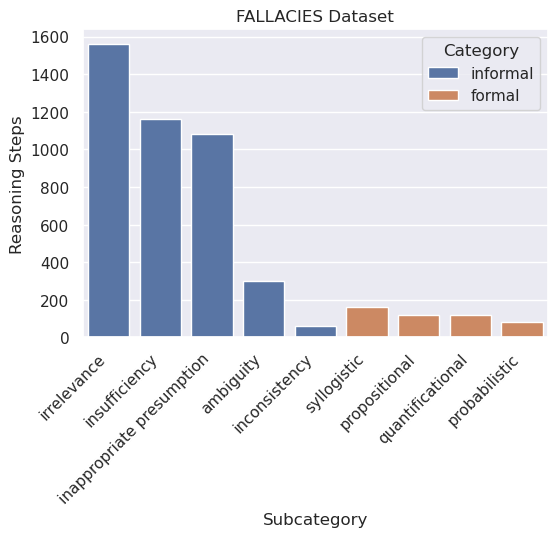

In [66]:
_, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='subcategory', y='count', data=df_fallacies_count, hue='category', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title('FALLACIES Dataset')
plt.xlabel('Subcategory')
plt.ylabel('Reasoning Steps')
plt.legend(title='Category')

plt.show()

- The FALLACIES dataset contains 4640 reasoning steps, divided into 232 different fallacy types.
- For each fallacy type, there are 10 correct and 10 incorrect reasoning steps.
- The fallacy types are grouped into 4 formal and 5 informal subcategories.
- There are more informal than formal fallacy types.
- To account for category and subcategory imbalance, the accuracies are based on macro-averaging.


## Experiment 1: Fallacy Identification with zero-shot Prompt

In [67]:
score_fallacy_identification(df_fallacies_e1)

df_fallacies_e1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          4640 non-null   object
 1   entity                        4640 non-null   object
 2   fallacy                       4640 non-null   object
 3   label                         4640 non-null   int64 
 4   category                      4640 non-null   object
 5   subcategory                   4640 non-null   object
 6   gpt_4o_response               4640 non-null   object
 7   gpt_4_response                4640 non-null   object
 8   gpt_4o_mini_response          4640 non-null   object
 9   claude_3_5_sonnet_response    4640 non-null   object
 10  claude_3_opus_response        4640 non-null   object
 11  claude_3_haiku_response       4640 non-null   object
 12  gemini_1_5_pro_response       4640 non-null   object
 13  gemini_1_5_flash_r

### Global Accuracies

In [68]:
_, df_subcategory_accuracies_e1, df_category_accuracies_e1, df_global_accuracies_e1 = get_accuracies(df_fallacies_e1)

In [69]:
df_global_accuracies_e1 = df_global_accuracies_e1.sort_values('accuracy', ascending=False)
df_global_accuracies_e1

,accuracy
gpt_4,88.139394
gemini_1_5_pro,87.137212
gpt_4o,86.775211
claude_3_opus,83.946236
claude_3_5_sonnet,83.764299
gpt_4o_mini,83.049186
gemini_1_5_flash,82.152709
gemini_1_5_flash_8b,81.283724
claude_3_haiku,78.942127


- GPT-4 still performs best, despite being a relatively outdated model. The global accuracy of 88.1% is very close to the 87.7% obtained by Hong et al. (2024).
- The flagship models GPT-4, Gemini 1.5 Pro, and Claude 3.5 Sonnet perform similarly.
- The lightweight models fall off in accuracy, but still achieve better results than the weaker models in the study by Hong et al. (2024).

### Fallacy Category Accuracies

In [70]:
df_category_accuracies_e1

category,formal,informal
gpt_4,88.125,88.153787
gpt_4o,85.416667,88.133756
gpt_4o_mini,79.010417,87.087956
claude_3_5_sonnet,85.0,82.528598
claude_3_opus,84.791667,83.100806
claude_3_haiku,75.677083,82.207172
gemini_1_5_pro,87.552083,86.72234
gemini_1_5_flash,81.614583,82.690834
gemini_1_5_flash_8b,78.854167,83.713282


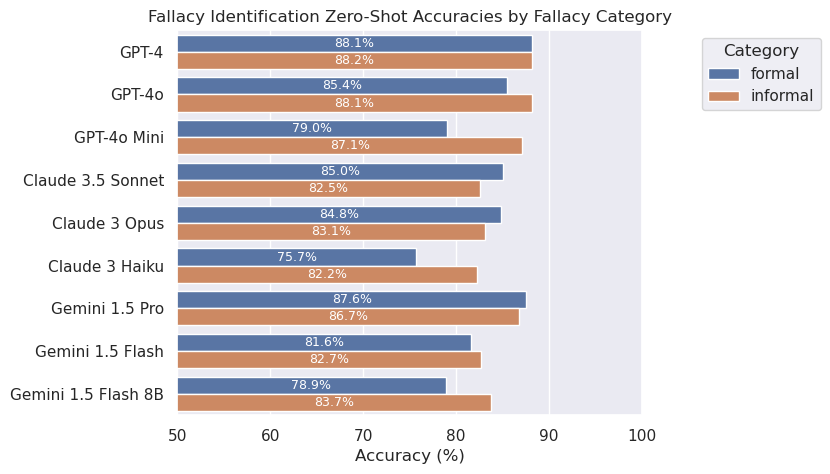

In [71]:
df_category_accuracies_long_e1 = pd.melt(df_category_accuracies_e1, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e1),
    figsize=(6, 5),
    title='Fallacy Identification Zero-Shot Accuracies by Fallacy Category',
    hue='category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

- Lightweight models like GPT-4o Mini, Claude 3 Haiku, and Gemini 1.5 Flash 8B perform worse on formal compared to informal fallacy identification. This replicates the findings by Hong et al. (2024).
- The flagship models perform similarly on formal and informal fallacy identification.

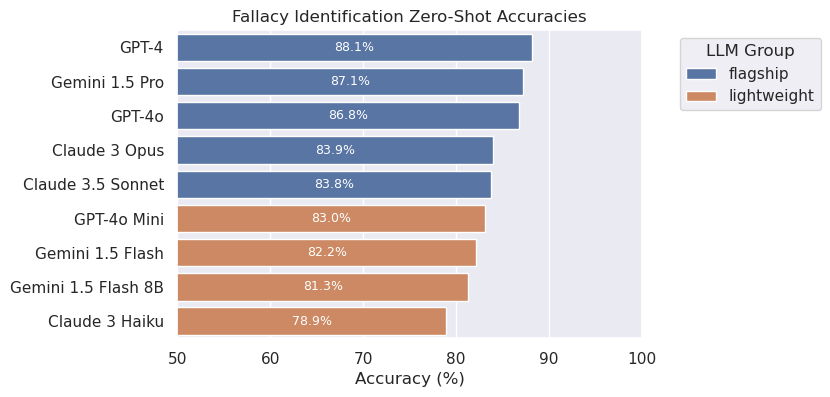

In [72]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e1),
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies',
    hue='llm_group',
    legend_title='LLM Group',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

In [73]:
df_plot = add_llm_info(df_category_accuracies_long_e1, group=True).groupby(['llm_group', 'category']).mean().reset_index()
df_plot

,llm_group,category,accuracy
0,flagship,formal,86.177083
1,flagship,informal,85.727857
2,lightweight,formal,78.789062
3,lightweight,informal,83.924811


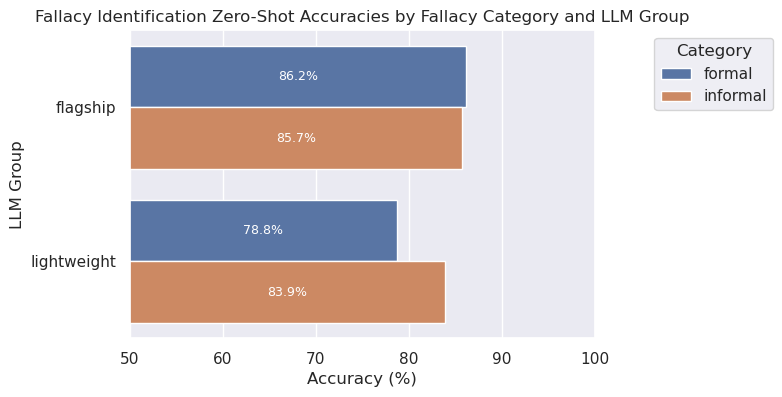

In [74]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies by Fallacy Category and LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

- When grouping the LLMs into flagship and lightweight models, the underperformance of lightweight models on formal fallacies becomes more apparent.

### Fallacy Subcategory Accuracies

In [75]:
df_subcategory_accuracies_e1

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4                       86.25     93.333333        84.166667       88.75   
gpt_4o                       87.5     83.333333        80.833333        90.0   
gpt_4o_mini                  77.5          80.0        74.166667      84.375   
claude_3_5_sonnet           81.25     86.666667        80.833333       91.25   
claude_3_opus               83.75          85.0        86.666667       83.75   
claude_3_haiku              78.75     69.166667        74.166667      80.625   
gemini_1_5_pro              88.75          85.0        85.833333      90.625   
gemini_1_5_flash            76.25     81.666667        81.666667      86.875   
gemini_1_5_flash_8b         76.25          77.5        76.666667        85.0   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4                84.666667                 86.944444          85.0   
gpt_4o                    85.0                 87.037037     88.333333   
gpt_4o_mini          84.333333                 87.037037     86.666667   
claude_3_5_sonnet    78.666667                 84.259259     81.666667   
claude_3_opus             82.0                 83.981481     83.333333   
claude_3_haiku            81.0                 83.148148     78.333333   
gemini_1_5_pro       85.666667                 88.055556          80.0   
gemini_1_5_flash          80.0                 84.444444     81.666667   
gemini_1_5_flash_8b  81.666667                  84.62963     81.666667   

category                                       
subcategory         insufficiency irrelevance  
gpt_4                   93.965517   90.192308  
gpt_4o                  92.413793   87.884615  
gpt_4o_mini              91.12069   86.282051  
claude_3_5_sonnet       86.896552   81.153846  
claude_3_opus           86.637931   79.551282  
claude_3_haiku          85.862069   82.692308  
gemini_1_5_pro          92.068966   87.820513  
gemini_1_5_flash        86.637931   80.705128  
gemini_1_5_flash_8b     88.103448        82.5

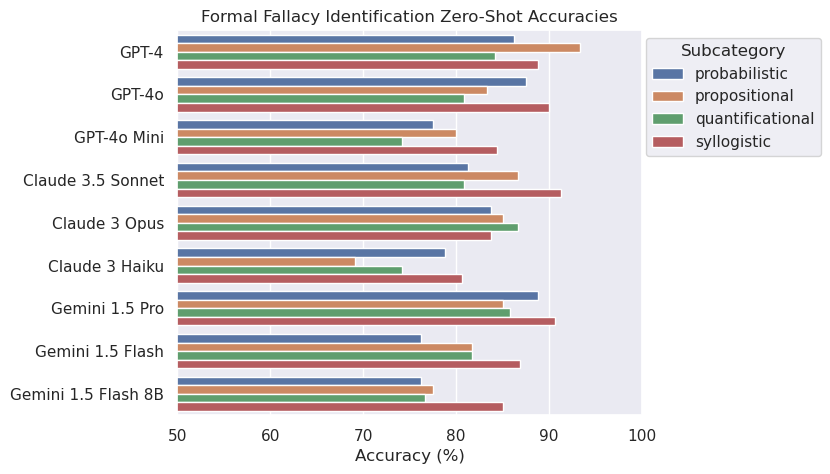

In [76]:
df_subcategory_accuracies_long_e1 = pd.melt(df_subcategory_accuracies_e1, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e1 = df_subcategory_accuracies_long_e1[
    df_subcategory_accuracies_long_e1['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e1),
    figsize=(6, 5),
    title='Formal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

In [77]:
df_plot = add_llm_info(df_formal_accuracies_long_e1, group=True).groupby(['llm_group', 'category', 'subcategory']).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,flagship,formal,probabilistic,85.5
1,flagship,formal,propositional,86.666667
2,flagship,formal,quantificational,83.666667
3,flagship,formal,syllogistic,88.875
4,lightweight,formal,probabilistic,77.1875
5,lightweight,formal,propositional,77.083333
6,lightweight,formal,quantificational,76.666667
7,lightweight,formal,syllogistic,84.21875


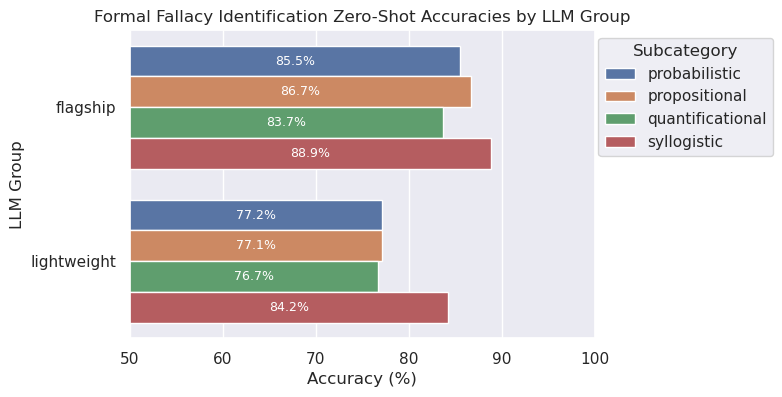

In [78]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Identification Zero-Shot Accuracies by LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

- The flagship LLMs perform well on all formal fallacy subcategories.
- The lightweight LLMs perform well on syllogistic formal fallacies, but fall off for the other subcategories.

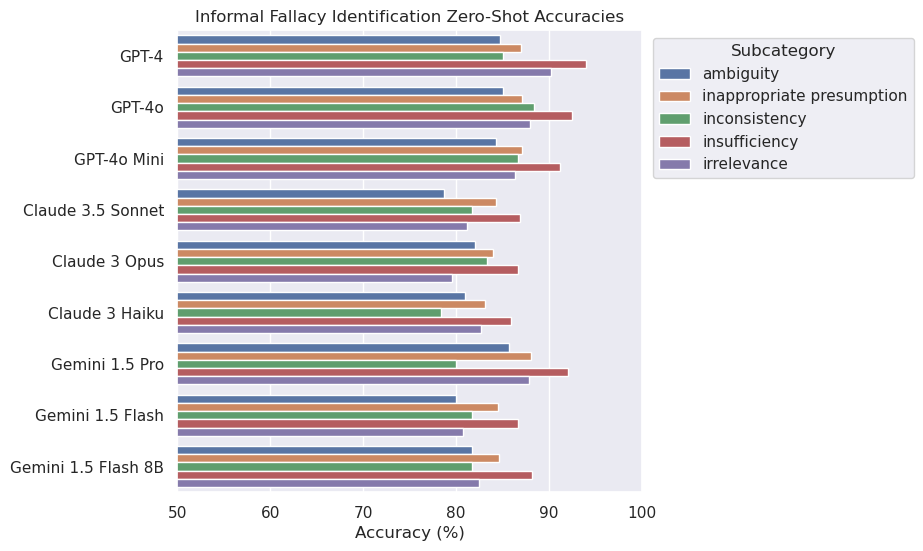

In [79]:
df_informal_accuracies_long_e1 = df_subcategory_accuracies_long_e1[
    df_subcategory_accuracies_long_e1['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e1),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

In [80]:
df_plot = add_llm_info(df_informal_accuracies_long_e1, group=True).groupby(['llm_group', 'category', 'subcategory']).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,flagship,informal,ambiguity,83.2
1,flagship,informal,inappropriate presumption,86.055556
2,flagship,informal,inconsistency,83.666667
3,flagship,informal,insufficiency,90.396552
4,flagship,informal,irrelevance,85.320513
5,lightweight,informal,ambiguity,81.75
6,lightweight,informal,inappropriate presumption,84.814815
7,lightweight,informal,inconsistency,82.083333
8,lightweight,informal,insufficiency,87.931034
9,lightweight,informal,irrelevance,83.044872


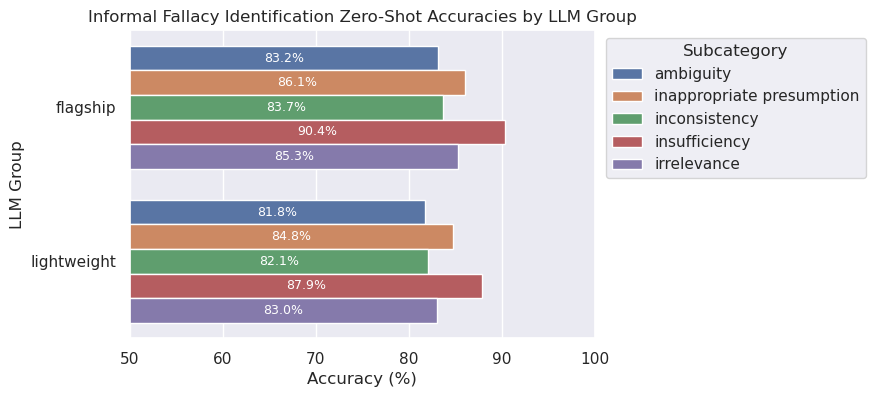

In [81]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Identification Zero-Shot Accuracies by LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=True,
    xlim=(50, 100),
)

- For informal fallacies, the lightweight LLMs perform a bit worse on all subcategories compared to the flagship LLMs, but they show the same pattern.
- The LLMs perform best for insufficiency fallacies (the premises are insufficient or weak to support the conclusion).

## Experiment 2: Fallacy Identification with few-shot Prompt

In [82]:
df_fallacies_e2 = get_fallacy_df('data/fallacies_e2.csv')

[2024-10-23 12:00:37] Loaded existing fallacy dataframe from data/fallacies_e2.csv.


In [83]:
score_fallacy_identification(df_fallacies_e2)

df_fallacies_e2.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No.,Yes.,No.,No.,No,No,1,1,1,1,0,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,No.,No,No,1,1,1,1,1,1,1


In [84]:
df_fallacies_e2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          4640 non-null   object
 1   entity                        4640 non-null   object
 2   fallacy                       4640 non-null   object
 3   label                         4640 non-null   int64 
 4   category                      4640 non-null   object
 5   subcategory                   4640 non-null   object
 6   gpt_4o_response               4640 non-null   object
 7   claude_3_5_sonnet_response    4640 non-null   object
 8   gemini_1_5_pro_response       4640 non-null   object
 9   gpt_4o_mini_response          4640 non-null   object
 10  claude_3_haiku_response       4640 non-null   object
 11  gemini_1_5_flash_response     4640 non-null   object
 12  gemini_1_5_flash_8b_response  4640 non-null   object
 13  gpt_4o_score      

Very few responses contain invalid values. However, the prompts causing these invalid responses are of questionable quality or contain politically incorrect language. These responses are ignored when calculating the accuracies.

The *Gemini 1.5 Flash* and *Claude 3 Haiku* LLMs had some issues with the few shot prompts, responding with "Yes No No Yes Yes" sometimes.


In [85]:
# Show invalid responses
df_fallacies_e2[df_fallacies_e2.isna().any(axis=1)]

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
37,Since I claim that benzopyran has magical prop...,benzopyran,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes.,Yes.,Yes.,Yes.,Yes.,Yes No No Yes Yes,Yes,1,1,1,1,1,<NA>,1
57,Since seining is a traditional fishing method ...,seining,Political Correctness Fallacy,0,informal,irrelevance,Yes.,No.,Yes.,Yes.,No.,Yes No No Yes,No.,1,1,0,0,1,<NA>,0
69,Since I am either eating capulins or I am alle...,capulins,Affirming a Disjunct,1,formal,propositional,Yes.,Yes.,Yes.,No.,No.,Yes No No Yes Yes,Yes,0,1,0,1,0,<NA>,0
73,Since I need to buy either gold or hemalyke fo...,hemalyke,Affirming a Disjunct,0,formal,propositional,Yes.,Yes.,Yes.,Yes.,Yes.,Yes No No Yes Yes,Yes,1,1,1,1,1,<NA>,1
90,Since some ctenuchid moths are known to be act...,ctenuchid,gish gallop,0,informal,irrelevance,Yes.,Yes.,Yes. No. No. Yes. Yes. Yes. Yes.,Yes.,No.,Yes No No Yes,Yes.,1,1,1,0,<NA>,<NA>,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4530,Since most of the successful machinery we see ...,journal bearing,Survivorship Fallacy,0,informal,insufficiency,Yes.,Yes.,Yes.,Yes.,No.,Yes No No Yes,Yes,1,1,1,0,1,<NA>,1
4577,Since catching and selling cinclids is illegal...,cinclids,Appeal to the Law,0,informal,insufficiency,Yes.,Yes.,Yes.,Yes.,No.,Yes No No Yes Yes,Yes,1,1,1,0,1,<NA>,1
4591,Since I use a trundle wheel for measuring dist...,trundle wheel,Failure to Elucidate,0,informal,irrelevance,Yes.,Yes.,Yes.,Yes.,Yes.,Yes No No Yes Yes,Yes,1,1,1,1,1,<NA>,1
4593,Since I observed a changeable lizard in my gar...,changeable lizard,Failure to Elucidate,0,informal,irrelevance,No.,No.,No.,Yes.,No.,Yes No No Yes Yes,Yes,0,1,0,0,0,<NA>,1


### Global Accuracies

In [86]:
_, df_subcategory_accuracies_e2, df_category_accuracies_e2, df_global_accuracies_e2 = get_accuracies(df_fallacies_e2)

In [87]:
df_global_accuracies_e2 = df_global_accuracies_e2.sort_values('accuracy', ascending=False)
df_global_accuracies_e2

,accuracy
gemini_1_5_pro,85.709938
gpt_4o,85.473447
claude_3_5_sonnet,85.39816
gpt_4o_mini,84.163461
gemini_1_5_flash,78.800249
gemini_1_5_flash_8b,77.567329
claude_3_haiku,71.720796


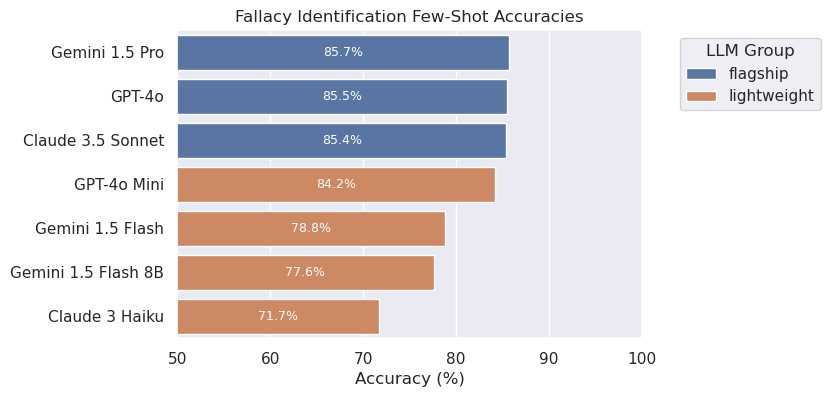

In [88]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e2),
    figsize=(6, 4),
    title='Fallacy Identification Few-Shot Accuracies',
    hue='llm_group',
    legend_title='LLM Group',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)


### Fallacy Category Accuracies

In [89]:
df_category_accuracies_e2

category,formal,informal
gpt_4o,84.791667,86.155226
gpt_4o_mini,81.979167,86.347755
claude_3_5_sonnet,85.78125,85.01507
claude_3_haiku,69.79989,73.641702
gemini_1_5_pro,84.947917,86.47196
gemini_1_5_flash,78.207914,79.392584
gemini_1_5_flash_8b,76.302083,78.832575


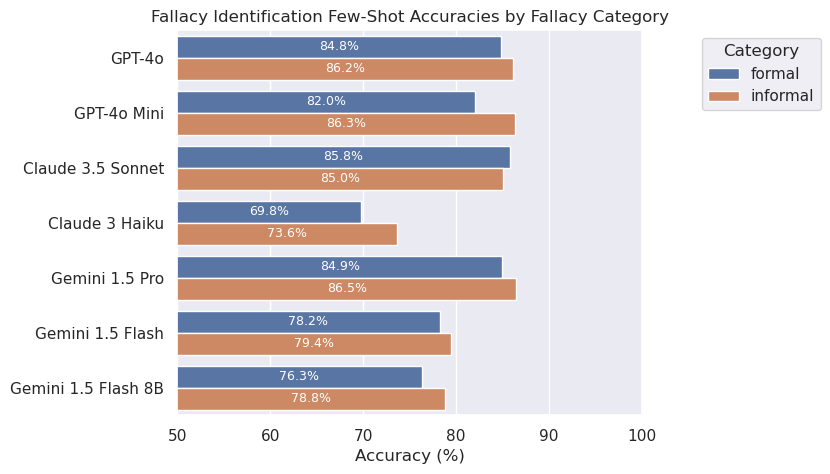

In [90]:
df_category_accuracies_long_e2 = pd.melt(df_category_accuracies_e2, var_name='category', value_name='accuracy', ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e2),
    figsize=(6, 5),
    title='Fallacy Identification Few-Shot Accuracies by Fallacy Category',
    hue='category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [91]:
df_subcategory_accuracies_e2

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       87.5          85.0        76.666667        90.0   
gpt_4o_mini                 76.25     88.333333        75.833333        87.5   
claude_3_5_sonnet            85.0          82.5             85.0      90.625   
claude_3_haiku               70.0      61.27193             70.0   77.927632   
gemini_1_5_pro              86.25     83.333333        83.333333      86.875   
gemini_1_5_flash        73.896199     70.354031        80.815902   87.765523   
gemini_1_5_flash_8b          75.0          72.5        73.333333      84.375   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o               84.666667                  86.90685     83.333333   
gpt_4o_mini          84.333333                 87.314815     81.666667   
claude_3_5_sonnet         83.0                 84.259259     88.333333   
claude_3_haiku       73.754386                 75.251054     71.666667   
gemini_1_5_pro            85.0                 85.531189     83.333333   
gemini_1_5_flash      79.29379                 76.484151     87.719298   
gemini_1_5_flash_8b  79.982456                 78.148148     78.333333   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  90.258621   85.610661  
gpt_4o_mini             90.603448   87.820513  
claude_3_5_sonnet       86.982759        82.5  
claude_3_haiku          75.115128   72.421278  
gemini_1_5_pro               90.0   88.495277  
gemini_1_5_flash        75.931812    77.53387  
gemini_1_5_flash_8b     80.775862   76.923077

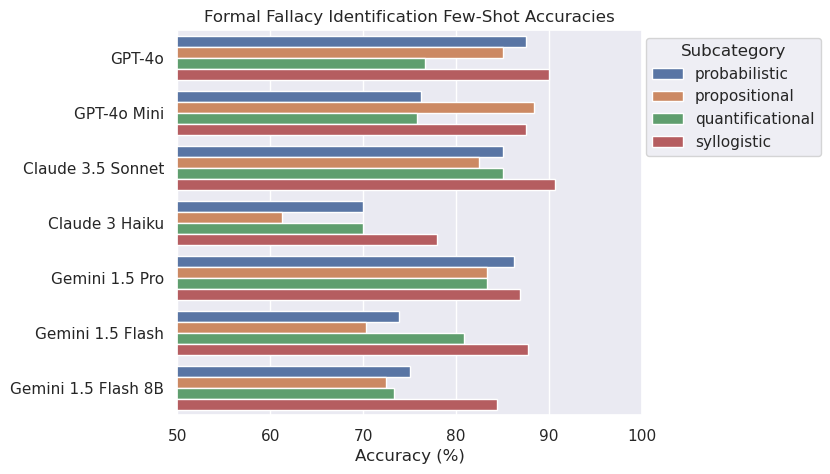

In [92]:
df_subcategory_accuracies_long_e2 = pd.melt(df_subcategory_accuracies_e2, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e2 = df_subcategory_accuracies_long_e2[
    df_subcategory_accuracies_long_e2['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e2),
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

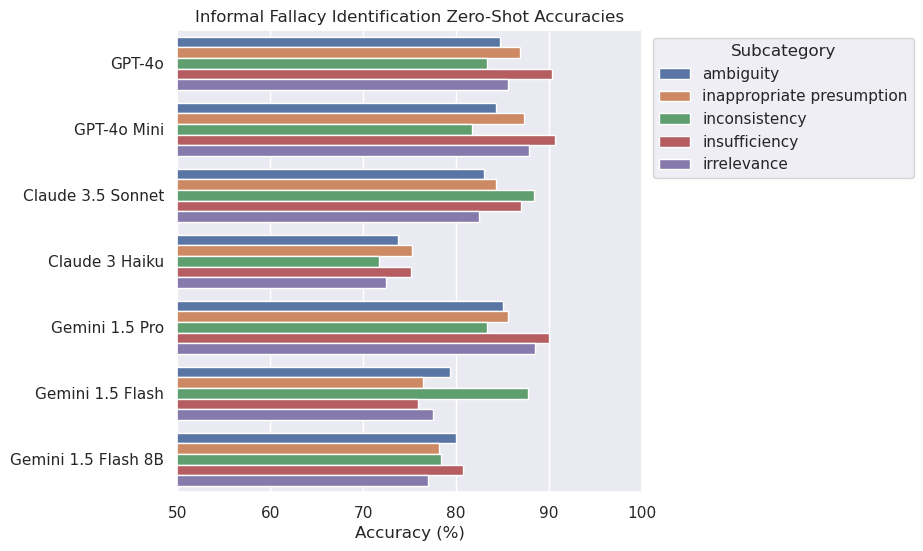

In [93]:
df_informal_accuracies_long_e2 = df_subcategory_accuracies_long_e2[
    df_subcategory_accuracies_long_e2['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e2),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

## Experiment 3: Fallacy Identification with chain-of-thought Prompt

In [94]:
df_fallacies_e3 = get_fallacy_df('data/fallacies_e3.csv')

[2024-10-23 12:00:39] Loaded existing fallacy dataframe from data/fallacies_e3.csv.


In [95]:
score_fallacy_identification(df_fallacies_e3)

df_fallacies_e3.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. Joh...,No. Silence is not necessarily an admission o...,No.,Let's analyze this step-by-step: 1. John aske...,No. Silence doesn't necessarily mean guilt or...,No. Silence doesn't necessarily mean agreemen...,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. Bob's s...,Let's think through this step by step: 1. Ali...,No. Silence could indicate a lack of knowledg...,No.,Let's analyze this step-by-step: 1. Alice ask...,No. Silence doesn't imply knowledge. Bob's s...,No. Silence does not equate to knowledge. Bo...,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The con...,Let's think through this step-by-step: 1. Ali...,No. Bob's silence doesn't confirm Alice's cla...,No.,Let's analyze this step-by-step: 1. Alice cla...,No. Bob's silence doesn't provide evidence su...,"No. Alice's claim, even if true, and Bob's si...",1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. The...,"No. While Tom's experience is valuable, the a...",No.,"Let's analyze this step-by-step: 1. Tom, a se...",No. The reasoning commits an appeal to author...,No. Just because one person says something an...,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The fac...,Let's think through this step-by-step: 1. Joh...,No. Silence does not imply guilt or fear. Ma...,No.,Let's analyze this step-by-step: 1. John accu...,No. Silence does not equal guilt or fear. Ma...,No. Silence in the face of an accusation does...,1,1,1,1,1,1,1


In [96]:
df_fallacies_e3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          4640 non-null   object
 1   entity                        4640 non-null   object
 2   fallacy                       4640 non-null   object
 3   label                         4640 non-null   int64 
 4   category                      4640 non-null   object
 5   subcategory                   4640 non-null   object
 6   gpt_4o_response               4640 non-null   object
 7   claude_3_5_sonnet_response    4640 non-null   object
 8   gemini_1_5_pro_response       4640 non-null   object
 9   gpt_4o_mini_response          4640 non-null   object
 10  claude_3_haiku_response       4640 non-null   object
 11  gemini_1_5_flash_response     4640 non-null   object
 12  gemini_1_5_flash_8b_response  4640 non-null   object
 13  gpt_4o_score      

Very few responses contain invalid values. However, the prompts causing these invalid responses are of questionable quality or contain politically incorrect language. These responses are ignored when calculating the accuracies.

In [97]:
# Show invalid responses
df_fallacies_e3_invalid = df_fallacies_e3[df_fallacies_e3.isna().any(axis=1)]
df_fallacies_e3_invalid.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,claude_3_haiku_response,gemini_1_5_flash_response,gemini_1_5_flash_8b_response,gpt_4o_score,gpt_4o_mini_score,claude_3_5_sonnet_score,claude_3_haiku_score,gemini_1_5_pro_score,gemini_1_5_flash_score,gemini_1_5_flash_8b_score
16,Since Samantha claims that wheelbirds exist in...,wheelbirds,Argument from Silence,0,informal,insufficiency,Yes. The reasoning is correct. Samantha's clai...,Let's think through this step by step: 1. Sam...,"Yes. Samantha's claim without evidence, coupl...",Yes.,Let's analyze this step-by-step: 1. Samantha ...,Yes,Yes.,1,1,<NA>,1,1,1,1
111,Since all bitrades are mathematical objects an...,bitrades,Fallacy of the Undistributed Middle,0,formal,syllogistic,Yes. The reasoning step is correct. The statem...,Let's think through this step-by-step: 1. We ...,Yes. The reasoning is that if two sets are bo...,Yes.,Let's analyze this step-by-step: 1. Premise: ...,Yes. This is a correct application of a simpl...,Yes,1,1,<NA>,1,1,1,1
183,Since dogs have skin and leather is made from ...,dogskin,Ambiguity Fallacy,1,informal,ambiguity,"Yes, the reasoning step is technically correct...",Let's break this down step by step: 1. Premis...,Yes. The logic is sound. While it might be d...,No.,Let's analyze this step-by-step: 1. Dogs have...,No. While the premises are true (dogs have sk...,Yes. The reasoning is logically sound.,0,1,0,<NA>,0,1,0
214,Since the planet is being polluted heavily by ...,tetroxids,Tokenism,0,informal,inappropriate presumption,Yes. Planting a single tree for each ton of te...,Let's break this down step by step: 1. The pl...,Yes,Yes.,Let's break down the reasoning step-by-step: ...,Yes. The reasoning correctly identifies a gest...,Yes. The reasoning is valid. Planting a sing...,1,1,1,<NA>,1,1,1
233,Since you are a nomologist who studies laws of...,nomologist,Appeal to the Moon,0,informal,irrelevance,Yes.,Let's break this down step by step: 1. You ar...,Yes. The reasoning connects the study of natu...,Yes.,Let's break down the reasoning step-by-step: ...,No. The reasoning is a non sequitur. While t...,No. The reasoning is a weak analogy. While s...,1,1,1,<NA>,1,0,0


### Global Accuracies

In [98]:
_, df_subcategory_accuracies_e3, df_category_accuracies_e3, df_global_accuracies_e3 = get_accuracies(df_fallacies_e3)

In [99]:
df_global_accuracies_e3 = df_global_accuracies_e3.sort_values('accuracy', ascending=False)
df_global_accuracies_e3

,accuracy
gpt_4o,88.180748
gemini_1_5_pro,84.736705
claude_3_5_sonnet,84.134798
claude_3_haiku,83.079349
gpt_4o_mini,81.568066
gemini_1_5_flash,80.193293
gemini_1_5_flash_8b,77.709173


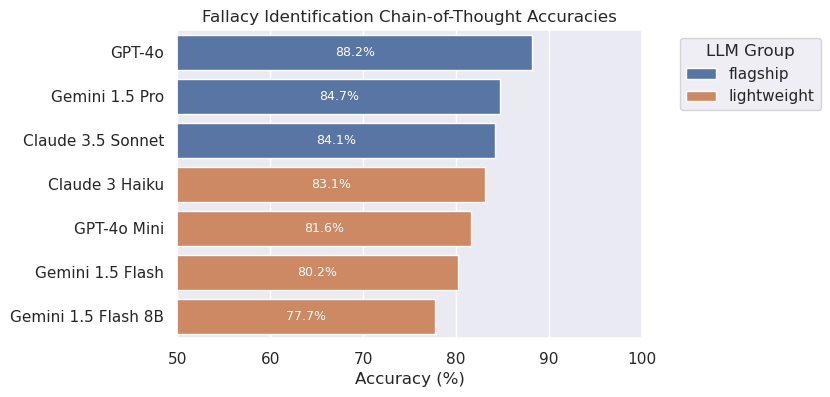

In [100]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e3),
    figsize=(6, 4),
    title='Fallacy Identification Chain-of-Thought Accuracies',
    hue='llm_group',
    legend_title='LLM Group',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Category Accuracies

In [101]:
df_category_accuracies_e3

category,formal,informal
gpt_4o,86.675858,89.685638
gpt_4o_mini,76.197917,86.938216
claude_3_5_sonnet,87.627924,80.641672
claude_3_haiku,79.127958,87.03074
gemini_1_5_pro,84.87564,84.59777
gemini_1_5_flash,80.948142,79.438444
gemini_1_5_flash_8b,75.3125,80.105845


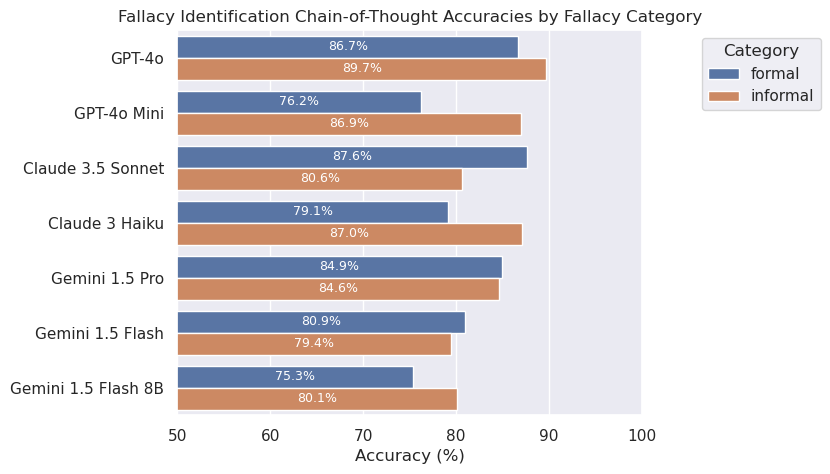

In [102]:
df_category_accuracies_long_e3 = pd.melt(df_category_accuracies_e3, var_name='category', value_name='accuracy',
                                         ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e3),
    figsize=(6, 5),
    title='Fallacy Identification Chain-of-Thought Accuracies by Fallacy Category',
    hue='category',
    legend_title='Category',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [103]:
df_subcategory_accuracies_e3

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       87.5     83.333333        84.411765   91.458333   
gpt_4o_mini                  77.5     74.166667             72.5      80.625   
claude_3_5_sonnet            85.0     90.833333        87.178363        87.5   
claude_3_haiku               77.5     74.824561        76.538462    87.64881   
gemini_1_5_pro               82.5     89.074074        79.868421   88.060065   
gemini_1_5_flash             77.5     81.666667        78.070175   86.555728   
gemini_1_5_flash_8b         76.25     70.833333        74.166667        80.0   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o               86.666667                 88.448668     91.666667   
gpt_4o_mini          83.666667                 87.962963     86.666667   
claude_3_5_sonnet    74.333333                 83.434048     81.666667   
claude_3_haiku       84.614035                 87.985164     87.894737   
gemini_1_5_pro       82.333333                 86.203704          80.0   
gemini_1_5_flash          80.0                  79.62963     81.666667   
gemini_1_5_flash_8b       78.0                 78.981481     83.333333   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  92.472777   89.173414  
gpt_4o_mini             90.689655   85.705128  
claude_3_5_sonnet       84.860681    78.91363  
claude_3_haiku          88.677983   85.981781  
gemini_1_5_pro          88.362069   86.089744  
gemini_1_5_flash        80.086207   75.809717  
gemini_1_5_flash_8b     82.586207   77.628205

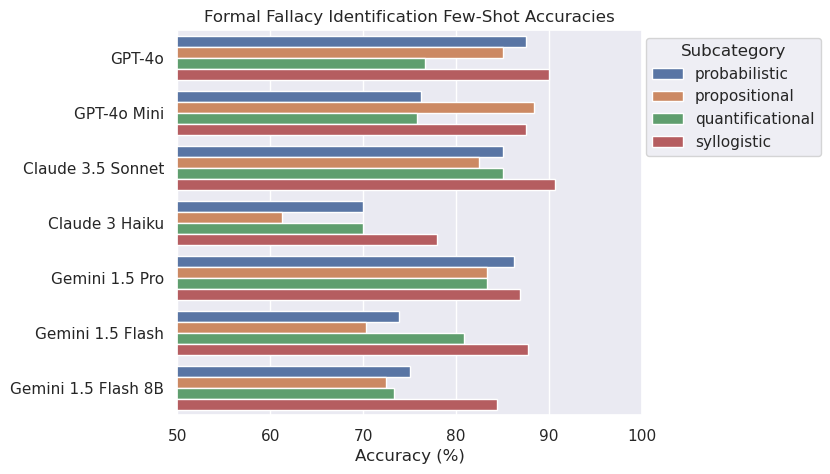

In [104]:
df_subcategory_accuracies_long_e3 = pd.melt(df_subcategory_accuracies_e3, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e3 = df_subcategory_accuracies_long_e2[
    df_subcategory_accuracies_long_e3['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e3),
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

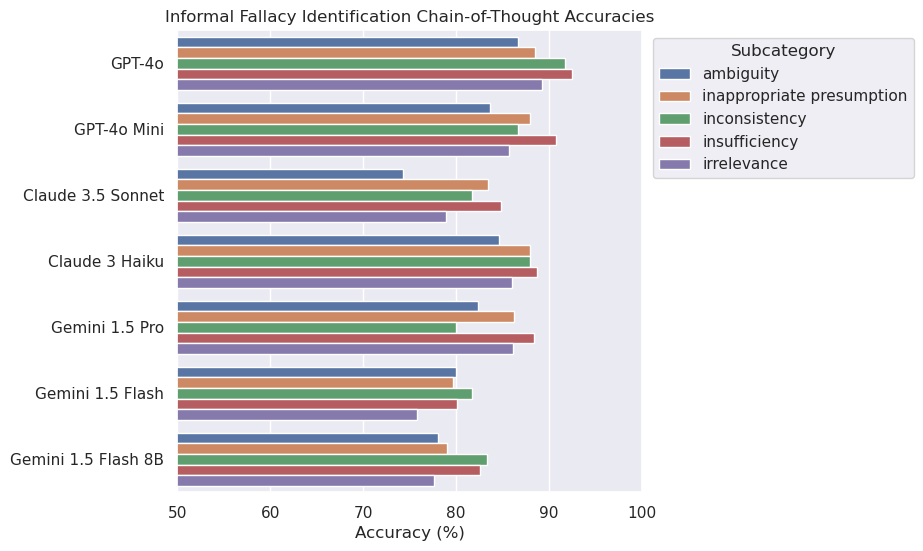

In [105]:
df_informal_accuracies_long_e3 = df_subcategory_accuracies_long_e3[
    df_subcategory_accuracies_long_e3['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e3),
    figsize=(6, 6),
    title='Informal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

## Prompt Method Comparison

In [106]:
df_global_accuracies_e1['method'] = 'zero-shot'
df_global_accuracies_e2['method'] = 'few-shot'
df_global_accuracies_e3['method'] = 'chain-of-thought'
df_accuracies_methods = pd.concat([df_global_accuracies_e1, df_global_accuracies_e2, df_global_accuracies_e3])

# Select models which have been prompted with all methods
df_accuracies_methods = df_accuracies_methods.loc[
    [LLM.GPT_4O.value, LLM.GEMINI_1_5_PRO.value, LLM.CLAUDE_3_5_SONNET.value,
     LLM.GPT_4O_MINI.value, LLM.GEMINI_1_5_FLASH.value, LLM.GEMINI_1_5_FLASH_8B.value, LLM.CLAUDE_3_HAIKU.value]
]

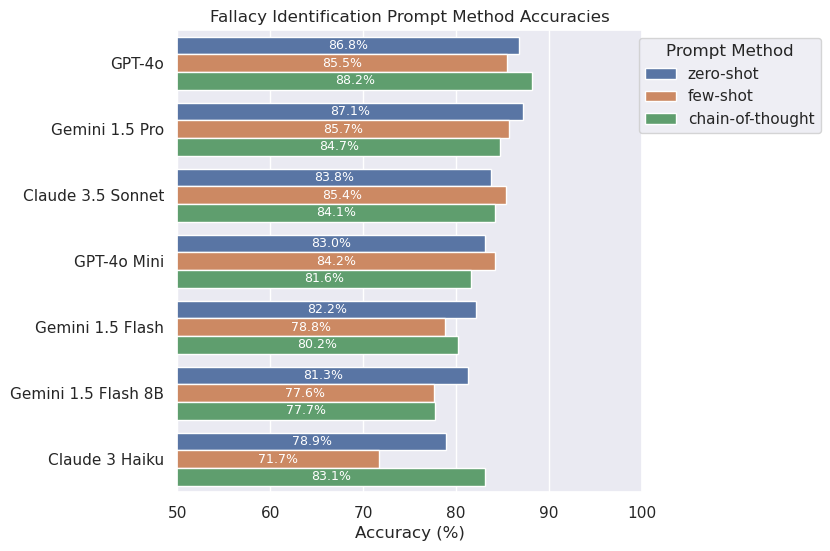

In [107]:
plot_accuracies(
    data=add_llm_info(df_accuracies_methods),
    figsize=(6, 6),
    title='Fallacy Identification Prompt Method Accuracies',
    hue='method',
    legend_title='Prompt Method',
    legend_anchor=(1.4, 1),
    annotate=True,
    xlim=(50, 100),
)

In [110]:
df_plot = add_llm_info(df_accuracies_methods, group=True).groupby(['llm_group', 'method']).mean().sort_values('method', ascending=False).reset_index()
df_plot

,llm_group,method,accuracy
0,flagship,zero-shot,85.892241
1,lightweight,zero-shot,81.356937
2,flagship,few-shot,85.527182
3,lightweight,few-shot,78.062959
4,flagship,chain-of-thought,85.684084
5,lightweight,chain-of-thought,80.63747


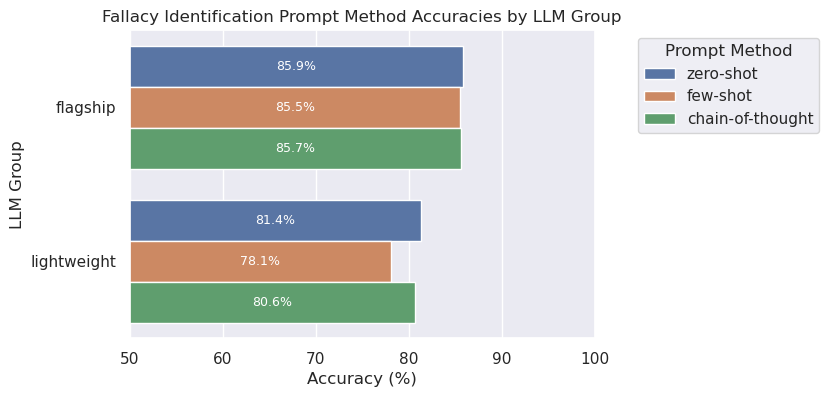

In [111]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Prompt Method Accuracies by LLM Group',
    y='llm_group',
    y_label='LLM Group',
    hue='method',
    legend_title='Prompt Method',
    legend_anchor=(1.5, 1),
    annotate=True,
    xlim=(50, 100),
)

- Few-shot and chain-of-thought prompts don't seem to improve the accuracies, compared to zero-shot prompts.
- Some of the lightweight models seem to get confused by few-shot prompts sometimes, responding with "Yes No No Yes Yes".